This notebook provides statistics on the results of our book clustering.


## Setup


In [1]:
library(tidyverse, warn.conflicts=FALSE)
library(arrow, warn.conflicts=FALSE)

Warning message:
“package ‘dplyr’ was built under R version 4.3.2”


Warning message:
“package ‘stringr’ was built under R version 4.3.2”


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Warning message:
“package ‘arrow’ was built under R version 4.3.2”


I want to use `theme_minimal()` by default:


In [2]:
theme_set(theme_minimal())

And default image sizes aren't great:


In [3]:
options(repr.plot.width  = 7,
        repr.plot.height = 4)

## Load Data

Let's start by getting our clusters and their statistics:


In [4]:
clusters = read_parquet("book-links/cluster-stats.parquet", as_data_frame=FALSE)
glimpse(clusters)

Table
40,570,400 rows x 8 columns
$ cluster        <int32> 423896385, 454491654, 424930878, 449145631, 440372971, …
$ n_nodes       <uint32> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ n_isbns       <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_loc_recs    <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_ol_editions <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_ol_works    <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_gr_books    <uint32> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ n_gr_works    <uint32> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…


Describe the count columns for basic descriptive stats:


In [5]:
clusters %>%
  select(-cluster) %>%
  collect() %>%
  summary()

    n_nodes             n_isbns           n_loc_recs        n_ol_editions     
 Min.   :     1.00   Min.   :    0.00   Min.   :   0.0000   Min.   :    0.00  
 1st Qu.:     2.00   1st Qu.:    0.00   1st Qu.:   0.0000   1st Qu.:    1.00  
 Median :     3.00   Median :    1.00   Median :   0.0000   Median :    1.00  
 Mean   :     3.39   Mean   :    1.09   Mean   :   0.2384   Mean   :    1.14  
 3rd Qu.:     4.00   3rd Qu.:    2.00   3rd Qu.:   0.0000   3rd Qu.:    1.00  
 Max.   :105055.00   Max.   :50785.00   Max.   :1439.0000   Max.   :43970.00  
   n_ol_works          n_gr_books         n_gr_works       
 Min.   :   0.0000   Min.   :   0.000   Min.   :  0.00000  
 1st Qu.:   1.0000   1st Qu.:   0.000   1st Qu.:  0.00000  
 Median :   1.0000   Median :   0.000   Median :  0.00000  
 Mean   :   0.8291   Mean   :   0.058   Mean   :  0.03751  
 3rd Qu.:   1.0000   3rd Qu.:   0.000   3rd Qu.:  0.00000  
 Max.   :2329.0000   Max.   :7380.000   Max.   :296.00000  

75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?


In [6]:
src_counts = clusters %>%
  summarize(across(-cluster, ~ sum(.x > 0))) %>%
  collect() %>%
  pivot_longer(everything(), names_to="source", values_to="count")
src_counts

source,count
<chr>,<int>
n_nodes,40570400
n_isbns,23953774
n_loc_recs,9278233
n_ol_editions,34071860
n_ol_works,32228071
n_gr_books,1505252
n_gr_works,1504728


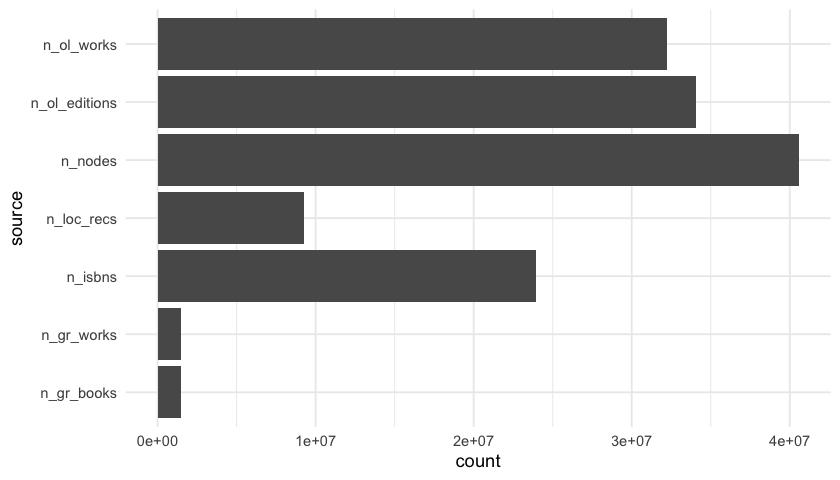

In [7]:
ggplot(src_counts, aes(y=source, x=count)) +
  geom_bar(stat='identity')

## Distributions

Let's look at the distributions of cluster sizes.  Let's first compute histograms
of the number of records per cluster for each cluster type.


In [8]:
size_dists = collect(clusters) %>%
  gather(rec_type, nrecs, -cluster, factor_key=TRUE) %>%
  summarize(count=n(), .by=c("rec_type", "nrecs"))
head(size_dists)

rec_type,nrecs,count
<fct>,<int>,<int>
n_nodes,2,10209603
n_nodes,1,6967016
n_nodes,3,9138176
n_nodes,4,8093059
n_nodes,5,2145067
n_nodes,6,1103729


Warning message:
“Transformation introduced infinite values in continuous x-axis”


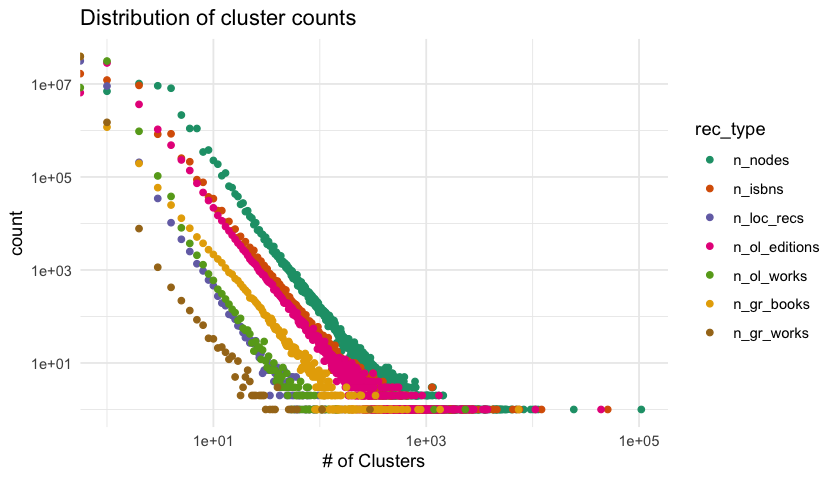

In [9]:
ggplot(size_dists) +
  aes(x=nrecs, y=count, color=rec_type) +
  geom_point() +
  scale_x_log10() +
  scale_y_log10() +
  scale_color_brewer(type="qual", palette="Dark2") +
  xlab("# of Records") +
  xlab("# of Clusters") +
  ggtitle("Distribution of cluster counts")

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

What's going on with these clusters? Let's take a peek at them.


In [10]:
gr_big = clusters %>%
  filter(n_gr_works > 1) %>%
  arrange(desc(n_gr_works))
gr_big %>% glimpse()

Table (query)
10,044 rows x 8 columns
$ cluster        <int32> 100059755, 100032170, 100156279, 100124809, 100428296, …
$ n_nodes       <uint32> 105055, 9584, 513, 1602, 315, 337, 513, 304, 685, 610, …
$ n_isbns       <uint32> 50785, 4624, 192, 780, 141, 91, 225, 120, 245, 299, 248…
$ n_loc_recs    <uint32> 1439, 281, 6, 55, 1, 38, 6, 3, 2, 0, 0, 1, 113, 105, 0,…
$ n_ol_editions <uint32> 43970, 3720, 110, 462, 51, 64, 113, 75, 185, 170, 153, …
$ n_ol_works    <uint32> 1185, 341, 75, 78, 18, 58, 38, 21, 75, 45, 47, 25, 144,…
$ n_gr_books    <uint32> 7380, 513, 69, 172, 53, 46, 91, 45, 140, 60, 51, 46, 59…
$ n_gr_works    <uint32> 296, 105, 61, 55, 51, 40, 40, 40, 38, 36, 34, 31, 30, 3…
Call `print()` for query details


We have a lot of these clusters. What fraction of the GoodReads-affected clusters is this?


In [11]:
nrow(gr_big) / sum(!is.na(clusters$n_gr_books))

Scalar
0.00024756965669552186

Less than 1%. Not bad, but let's look at these largest clusters.


In [12]:
gr_big %>% head() %>% collect()

cluster,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
100059755,105055,50785,1439,43970,1185,7380,296
100032170,9584,4624,281,3720,341,513,105
100156279,513,192,6,110,75,69,61
100124809,1602,780,55,462,78,172,55
100428296,315,141,1,51,18,53,51
100673490,337,91,38,64,58,46,40


## Large Cluster Debugging

We have some pretty big clusters:


In [13]:
big = clusters %>% slice_max(n_nodes, n=5, with_ties=FALSE) %>%
  collect()
big

cluster,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
100059755,105055,50785,1439,43970,1185,7380,296
100510835,24374,12126,190,10610,68,1352,28
108162346,11281,7520,0,3760,1,0,0
102285712,10678,7118,0,3559,1,0,0
100148394,10118,6518,7,3558,35,0,0


What is up with this? We should figure out what went wrong, if we can.  What are its ISBNs?


In [14]:
isbns = read_parquet('book-links/all-isbns.parquet', as_data_frame=FALSE)
glimpse(isbns)

Table
44,259,065 rows x 7 columns
$ isbn_id     <int32> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…
$ isbn <large_string> "9780745655833", "9780270988932", "8806253239", "303000520…
$ LOC        <uint32> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1…
$ OL         <uint32> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1…
$ GR          <int64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0…
$ AZ14       <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ AZ18       <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…


In [15]:
links = read_parquet("book-links/isbn-clusters.parquet", as_data_frame=FALSE) %>%
  select(isbn_id, cluster)
glimpse(links)

Table (query)
44,259,065 rows x 2 columns
$ isbn_id <int32> 44259065, 44259064, 44259063, 44259062, 44259061, 44259060, 44…
$ cluster <int32> 944259065, 944259064, 944259063, 944259062, 944259061, 9442590…
Call `print()` for query details


Now let's look up data for the largest cluster.


In [16]:
big_id = big$cluster[1]
big_id

[1] 100059755

In [17]:
bl = links %>% filter(cluster == big_id)
bl = semi_join(isbns, bl) %>% arrange(isbn)
bl %>% glimpse()

Table (query)
?? rows x 7 columns
$ isbn_id     <int32> 42150376, 42057227, 2253134, 22020104, 32796312, 10498136,…
$ isbn <large_string> "0000744395", "000074445X", "0001004735", "0001004743", "0…
$ LOC        <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0…
$ OL         <uint32> 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 3, 1…
$ GR          <int64> 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0…
$ AZ14       <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ AZ18       <uint32> 0, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
Call `print()` for query details


What are the things with the highest record count?


In [18]:
bl %>% collect() %>% rowwise() %>% mutate(
  btot = sum(c_across(!starts_with("isbn")))
) %>% slice_max(btot, n=20)

isbn_id,isbn,LOC,OL,GR,AZ14,AZ18,btot
<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
42150376,0000744395,0,0,1,0,0,1
42057227,000074445X,0,0,1,0,0,1
2253134,0001004735,0,1,0,0,0,1
22020104,0001004743,0,1,0,0,0,1
32796312,0001034375,0,1,0,0,0,1
10498136,0001046403,0,1,0,0,0,1
40574457,0001049283,0,1,0,0,0,1
1074304,0001054783,0,1,0,0,75,76
27407159,0001385208,0,1,0,0,0,1
